# regression example - house price dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import copy
import dill
import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal
from lightgbm import LGBMRegressor
import treelite
import treelite_runtime
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
cmap = sns.color_palette("viridis", as_cmap=True)
cmap = sns.color_palette("vlag", as_cmap=True)

**Gators** imports

In [4]:
from gators.util import util
# sampling
from gators.sampling import UnsupervisedSampling
# data cleaninng
from gators.data_cleaning import (
    DropHighNaNRatio,
    DropLowCardinality,
    DropHighCardinality,
    DropDatatypeColumns,
    DropColumns,
    KeepColumns,
)
# imputers
from gators.imputers import (
    NumericsImputer, 
    ObjectImputer,
)
# encoders
from gators.encoders import (
    WOEEncoder, 
    TargetEncoder,
    OrdinalEncoder, 
)
# binning
from gators.binning import (
    BinRareCategories,
    TreeBinning,
)
# feature generation
from gators.feature_generation import (
    ClusterStatistics,
    PolynomialFeatures,
    PolynomialObjectFeatures,
)
# feature selection
from gators.feature_selection import (
    InformationValue,
    SelectFromModel,
)
# model building
from gators.model_building import (
    TrainTestSplit,
    XGBBoosterBuilder,
    XGBTreeliteDumper,
    LGBMTreeliteDumper,
)
# # pipeline
from gators.pipeline import Pipeline

## data analysis

In [5]:
data = pd.read_parquet('data/house_prices.parquet').reset_index(drop=True)
y = data['SalePrice']
y = y.astype(float)
X = data.drop('SalePrice', axis=1)

train_test_split = TrainTestSplit(test_ratio=0.3, strategy='ordered')
X_train, X_test, y_train, y_test = train_test_split.transform(X, y)

In [6]:
X_train.head(2)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave  None      Reg   
1          20       RL         80.0     9600   Pave  None      Reg   

  LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC Fence  \
0         Lvl    AllPub    Inside  ...           0        0   None  None   
1         Lvl    AllPub       FR2  ...           0        0   None  None   

  MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
0        None       0       2    2008        WD         Normal  
1        None       0       5    2007        WD         Normal  

[2 rows x 79 columns]

count           mean           std      min       25%       50%  \
SalePrice  1022.0  181713.254403  79854.663341  34900.0  130000.0  163745.0   

                75%       max  
SalePrice  214975.0  755000.0

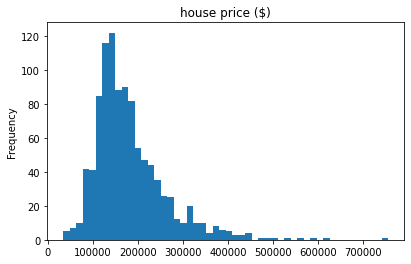

In [7]:
y_train.plot(
    kind='hist', 
    figsize=(4*1.6, 4),
    title='house price ($)',
    bins=50) ;
pd.DataFrame(y_train.describe()).T

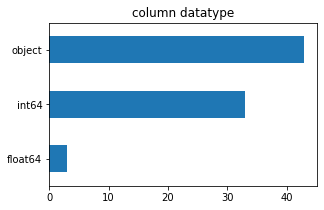

In [8]:
X_train.dtypes.value_counts(ascending=True).plot(
    figsize=(3*1.6, 3), 
    title='column datatype',
    kind='barh');

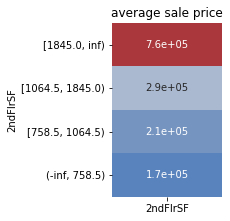

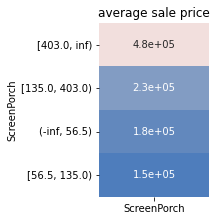

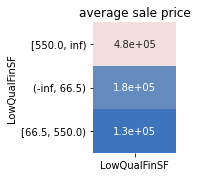

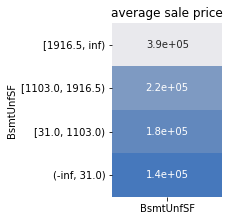

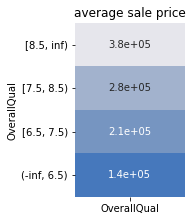

In [9]:
steps = [
    ('BinRareCategories', BinRareCategories(min_ratio=0.05)),
    ('DropLowCardinality', DropLowCardinality(min_categories=2)),
    ('ObjectImputer', ObjectImputer(strategy='constant', value='MISSING')),
    ('NumericsImputer', NumericsImputer(strategy='constant', value=0)),
    ('TreeBinning', TreeBinning(
        tree=DecisionTreeRegressor(max_depth=2, min_samples_split=50), inplace=True)),
    ('CleanCategories', BinRareCategories(min_ratio=0.0)),
    ('TargetEncoder', TargetEncoder()),
]
pipe = Pipeline(steps=steps)
_ = pipe.fit(X_train.copy(), y_train)
pipe.steps[-1][1].display_mapping(cmap=cmap, decimal=1, title='average sale price')

## offline pipeline - feature selection

In [10]:
k = 30
model = LGBMRegressor(random_state=0)
steps = [
    ('BinRareCategories', BinRareCategories(min_ratio=0.1)),
    ('ObjectImputer', ObjectImputer(strategy='constant', value='MISSING')),
    ('OrdinalEncoder', OrdinalEncoder()),
    ('NumericsImputer', NumericsImputer(strategy='constant', value=0)),
    ('CleanCategories', BinRareCategories(min_ratio=0.0)),
    ('SelectFromModel', SelectFromModel(model=model, k=k)),
]

In [11]:
pipe = Pipeline(steps=steps)
_ = pipe.fit(X_train.copy(), y_train)

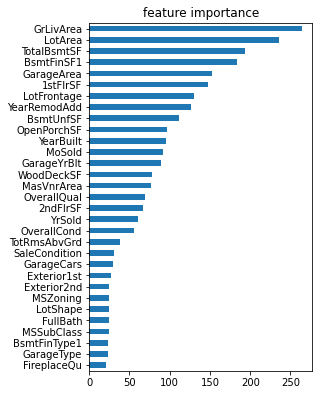

In [12]:
pipe.steps[-1][1].feature_importances_.iloc[k::-1].plot(
    kind='barh', 
    figsize=(4, 4*1.6), 
    title='feature importance',
);

In [13]:
selected_columns = pipe.steps[-1][1].selected_columns
polynomial_columns = pipe.steps[-1][1].feature_importances_.index[:5]

## pipeline optimization

In [14]:
from xgboost import XGBRegressor
model = XGBRegressor(random_state=0, objective='reg:squarederror', max_depth=2)

steps = [
    ('BinRareCategories', BinRareCategories(min_ratio=0.1)),
    ('ObjectImputer', ObjectImputer(strategy='constant', value='MISSING')),
    ('NumericsImputer', NumericsImputer(strategy='constant', value=-1)),
    ('CleanCategories', BinRareCategories(min_ratio=0.0)),
    ('TargetEncoder', TargetEncoder()),
    ('ESTIMATOR', model),
]

param_distributions = {
    "BinRareCategories__min_ratio": [0.05, 0.1, 0.2],
    "NumericsImputer__strategy": ["mean", "constant"],
    "ObjectImputer__strategy": ["constant", "most_frequent"],
    'ESTIMATOR__subsample': [0.5, 0.6, 0.7],
    'ESTIMATOR__colsample_bytree': [0.4, 0.5, 0.6],
    'ESTIMATOR__min_child_weight': [10, 20, 30],
}
scoring = make_scorer(mean_absolute_error)

cv = KFold(n_splits=10, random_state=0, shuffle=True)
pipe = Pipeline(steps=steps, verbose=False)
search = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions, 
    n_iter=3,
    cv=cv,
    n_jobs=-1,
    random_state=0,
    verbose=True)
_ = search.fit(X_train[selected_columns].copy(), y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


/Users/cpoli/gators38/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/cpoli/gators38/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/cpoli/gators38/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/cpoli/gators38/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with

In [15]:
columns = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'mean_test_score', 'std_test_score', 'rank_test_score']
pd.DataFrame(search.cv_results_)[columns].sort_values('rank_test_score').iloc[:5]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       1.639170      0.034378         0.049366        0.010373   
2       1.239296      0.044473         0.039315        0.002073   
1       1.515153      0.146610         0.052766        0.008797   

   mean_test_score  std_test_score  rank_test_score  
0         0.858874        0.052009                1  
2         0.845244        0.055399                2  
1         0.843845        0.048997                3

## model evaluation

In [17]:
search.best_estimator_.predict(X_train[selected_columns])

array([212763.14, 168374.55, 209336.47, ..., 187853.05, 170102.27,
       198109.14], dtype=float32)

In [18]:
train_error = mean_absolute_error(
    y_train, search.best_estimator_.predict(X_train[selected_columns]))
print(f'mean absolute error - train set: {round(train_error)}')
test_error = mean_absolute_error(
    y_test, search.best_estimator_.predict(X_test[selected_columns]))
print(f'mean absolute error - test set: {round(test_error)}')

mean absolute error - train set: 14160
mean absolute error - test set: 19255


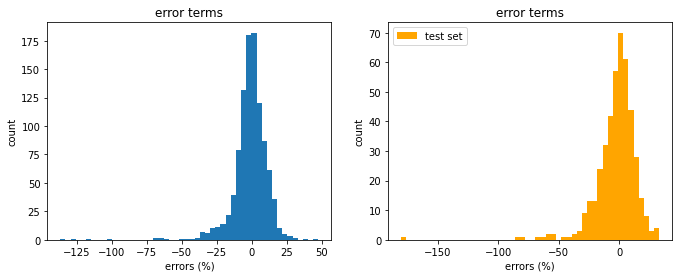

In [19]:
train_errors = 100 * (y_train - search.best_estimator_.predict(X_train[selected_columns])) / y_train
test_errors = 100 * (y_test - search.best_estimator_.predict(X_test[selected_columns])) / y_test
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(1, 2, figsize=[7 *1.6, 4]);
ax[0].hist(train_errors, bins=50, label='train set');
ax[0].set_title('error terms');
ax[0].set_xlabel('errors (%)');
ax[0].set_ylabel('count');
ax[1].hist(test_errors, bins=50, label='test set', color='orange');
ax[1].set_title('error terms');
ax[1].set_xlabel('errors (%)');
ax[1].set_ylabel('count');
plt.legend();

## production pipeline & model

In [20]:
prod_pipe = copy.deepcopy(search.best_estimator_)
_ = prod_pipe.steps.pop(-1)
model_pd = copy.deepcopy(search.best_estimator_.steps[-1][1])

In [21]:
X_train_prepro_np = prod_pipe.transform_numpy(X_train[selected_columns].to_numpy())
y_train_np = y_train.to_numpy()

In [22]:
X_train_prepro_np = prod_pipe.transform_numpy(X_train[selected_columns].copy().to_numpy())
y_train_np = y_train.to_numpy()

xgb_booster = XGBBoosterBuilder.train(
    model=model_pd, 
    X_train=X_train_prepro_np, 
    y_train=y_train.to_numpy(),
)

treelite_model = treelite.Model.from_xgboost(xgb_booster)
treelite_model.export_lib(
    toolchain='gcc', 
    libpath='./models/test.so', 
    params={'parallel_comp': 4},
    verbose=True
)
model_prod = treelite_runtime.Predictor(
    './models/test.so', verbose=False)

[17:25:24] ../src/compiler/ast_native.cc:45: Using ASTNativeCompiler
[17:25:24] ../src/compiler/ast/split.cc:31: Parallel compilation enabled; member trees will be divided into 4 translation units.
[17:25:24] ../src/c_api/c_api.cc:121: Code generation finished. Writing code to files...
[17:25:24] ../src/c_api/c_api.cc:126: Writing file recipe.json...
[17:25:24] ../src/c_api/c_api.cc:126: Writing file tu3.c...
[17:25:24] ../src/c_api/c_api.cc:126: Writing file tu2.c...
[17:25:24] ../src/c_api/c_api.cc:126: Writing file tu1.c...
[17:25:24] ../src/c_api/c_api.cc:126: Writing file tu0.c...
[17:25:24] ../src/c_api/c_api.cc:126: Writing file header.h...
[17:25:24] ../src/c_api/c_api.cc:126: Writing file main.c...
[17:25:24] /Users/cpoli/gators38/lib/python3.8/site-packages/treelite/contrib/util.py:105: Compiling sources files in directory ./models/tmp2okzfo39 into object files (*.o)...
[17:25:24] /Users/cpoli/gators38/lib/python3.8/site-packages/treelite/contrib/util.py:134: Generating dynam

In [23]:
xgb_booster = XGBBoosterBuilder.train(
    model=model_pd, 
    X_train=X_train_prepro_np, 
    y_train=y_train_np,
)

treelite_model = treelite.Model.from_xgboost(xgb_booster)
treelite_model.export_lib(
    toolchain='gcc', 
    libpath=f'./models/treelite_lgbm_house.so', 
    params={'parallel_comp': 4},
    verbose=False
)
model_prod = treelite_runtime.Predictor(
    f'./models/treelite_lgbm_house.so', verbose=False)

[17:25:25] ../src/compiler/ast/split.cc:31: Parallel compilation enabled; member trees will be divided into 4 translation units.


In [24]:
X_test_np = X_test[selected_columns].to_numpy()
y_pred_pd = model_pd.predict(
    prod_pipe.transform(X_test[selected_columns].copy()))
y_pred_tl = model_prod.predict(
    treelite_runtime.DMatrix(
        prod_pipe.transform_numpy(
            X_test_np.copy()
        )
    )
)

### check if Pandas & Treelite predictions match

In [25]:
assert np.allclose(y_pred_pd, y_pred_tl)

## per-sample bechmarking

### pipeline only

In [26]:
x = X_test[selected_columns].iloc[[1]]
xnp = x.to_numpy()
stats_pd = %timeit -o prod_pipe.transform(x)
stats_np = %timeit -o prod_pipe.transform_numpy(xnp.copy())

20.1 ms ± 250 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
27.4 µs ± 844 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [27]:
speedup = 1e3 * float(str(stats_pd).split(' ')[0]) / float(str(stats_np).split(' ')[0])
f'Speed-up Pandas VS Numpy x{round(speedup)}'

'Speed-up Pandas VS Numpy x734'

### pipeline & model

In [28]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [29]:
stats_pd = %timeit -o model_pd.predict(prod_pipe.transform(x).copy())[0]
stats_tl = %timeit -o  model_prod.predict(treelite_runtime.DMatrix(prod_pipe.transform_numpy(xnp.copy())))

32.2 ms ± 2.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
78.7 µs ± 1.91 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [30]:
speedup = 1e3 * float(str(stats_pd).split(' ')[0]) / float(str(stats_tl).split(' ')[0])
f'Speed-up Pandas VS Numpy&Treelite x{round(speedup)}'

'Speed-up Pandas VS Numpy&Treelite x409'